## This code visualizes the features learned from AttentiveFP when learning water solubility
You can train the model yourself or load the previously trained model

In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  1128
number of successfully processed smiles:  1128


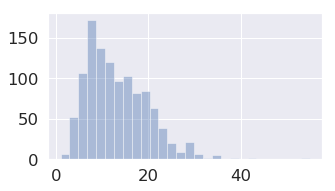

In [4]:
task_name = 'solubility'
tasks = ['measured log solubility in mols per litre']

raw_filename = "../data/delaney-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [3]:
random_seed = 2 
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800
p_dropout= 0.2
weight_decay = 5                 # also known as l2_regularization_lambda
learning_rate = 2.5              # both weight_decay and learning rate are rescaled by -log10()

fingerprint_dim = 200
radius = 2                       # number of Attentive layers for individual atom embedding
T = 2                            # number of Attentive layers for whole molecule embedding
per_task_output_units_num = 1    # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

C
feature dicts file saved as ../data/delaney-processed.pickle
not processed items


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,cano_smiles
934,Methane,-0.636,0,16.043,0,0,0,0.0,-0.9,C,C


In [6]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()


Train the model to see the visualization (if you want to see the visualization before training, just comment out the training procedure)

In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.35:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >10):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 3.7909765 3.7577767
1 2.6995106 2.6515882
2 1.8039856 1.715264
3 1.824946 1.7362673
4 1.7832699 1.6912572
5 1.6493977 1.508971
6 1.5683764 1.4216353
7 1.4425244 1.2821604
8 1.2099133 1.1927081
9 1.0881511 1.0634578
10 1.0577168 1.0828744
11 0.95452654 0.9207429
12 0.8988237 0.880393
13 0.84553355 0.84358704
14 0.80672026 0.7323729
15 0.8384148 0.75481075
16 0.7549069 0.7106614
17 0.7354223 0.7019493
18 0.70788485 0.7451683
19 0.69599605 0.74768263
20 0.6892277 0.73354405
21 0.7145938 0.81200475
22 0.6612223 0.7270667
23 0.6743078 0.68897706
24 0.79961264 0.9535181
25 0.7374241 0.80868787
26 0.69718236 0.81162506
27 0.67403954 0.74350476
28 0.6326513 0.71473145
29 0.6180651 0.6315237
30 0.6128362 0.6594719
31 0.6363269 0.64039654
32 0.62748766 0.64408636
33 0.5822068 0.639415
34 0.60591936 0.61052835
35 0.6087114 0.62631917
36 0.5654961 0.5980725
37 0.5510371 0.6217866
38 0.5606376 0.68093383
39 0.573793 0.6957307
40 0.5802347 0.73001343
41 0.59206986 0.725728
42 0.61321706 0.77814984

In [10]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 116 
 test RMSE: 0.5316298


In [11]:
# Feature visualization
# from AttentiveFP.AttentiveLayers_viz_not_activated import Fingerprint_viz
model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()


tensor(1, dtype=torch.uint8)

In [12]:
def eval_for_viz(model, viz_list):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    mol_prediction_list = []
    atom_feature_list = []
    atom_weight_list = []
    mol_feature_list = []
    mol_feature_unbounded_list = []
    batch_list = []
    for i in range(0, len(viz_list), batch_size):
        batch = viz_list[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(viz_list,get_smiles_dicts(batch))
        atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model(
            torch.Tensor(x_atom), torch.Tensor(x_bonds),
            torch.cuda.LongTensor(x_atom_index),
            torch.cuda.LongTensor(x_bond_index),
            torch.Tensor(x_mask))

        mol_prediction_list.append(mol_prediction.cpu().detach().squeeze().numpy())
        atom_feature_list.append(np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)]))
        atom_weight_list.append(np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_list.append(np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)]))
        mol_feature_unbounded_list.append(np.stack([mol_feature_unbounded_viz[t].cpu().detach().numpy() for t in range(T)]))
        
    mol_prediction_array = np.concatenate(mol_prediction_list,axis=0)
    atom_feature_array = np.concatenate(atom_feature_list,axis=1)
    atom_weight_array = np.concatenate(atom_weight_list,axis=1)
    mol_feature_array = np.concatenate(mol_feature_list,axis=1)
    mol_feature_unbounded_array = np.concatenate(mol_feature_unbounded_list,axis=1)
#     print(mol_prediction_array.shape, atom_feature_array.shape, atom_weight_array.shape, mol_feature_array.shape)
    return mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array


In [13]:
viz_list = ['CC(C)NC(=O)N1CC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O',
            'O=C(NC(=O)c1c(F)cccc1F)Nc1cc(Cl)c(F)c(Cl)c1F',
            'CC(=O)Oc1ccccc1C(=O)O']
    
mol_prediction_array, atom_feature_array, atom_weight_array, mol_feature_array, mol_feature_unbounded_array =  eval_for_viz(model_for_viz, viz_list)
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(viz_list,get_smiles_dicts(viz_list))
# viz_list = [
#     "CC(C)CNC(=O)N1CCNC1=O",
#     "CC(C)NC(=O)N1CC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O",
#     "CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO",
#     "CCC(Br)(CC)C(=O)NC(N)=O",
#     "Nc1ncnc2c1ccn2C1OC(CO)C(O)C1O",
#     "O=C(CC(Cl)Cl)NC1=C(Cl)C(=O)c2ccccc2C1=O",
#     "O=C(NC(=O)c1c(F)cccc1F)Nc1cc(Cl)c(F)c(Cl)c1F",
#     "O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl",
#     "O=C1CC(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21",
#     "O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12",
#     "OCC(O)C1OC2OC(C(Cl)(Cl)Cl)OC2C1O",
#     "OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O",
#     "OCC1OC(OCC2OC(OC3(CO)OC(CO)C(O)C3O)C(O)C(O)C2O)C(O)C(O)C1O",
#     "OCC1OC(n2cnc3c(O)ncnc32)C(O)C1O",
#     "OCc1ccccc1OC1OC(CO)C(O)C(O)C1O"
# ]

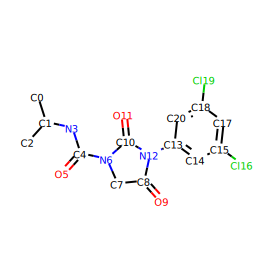

<Figure size 1800x1200 with 0 Axes>

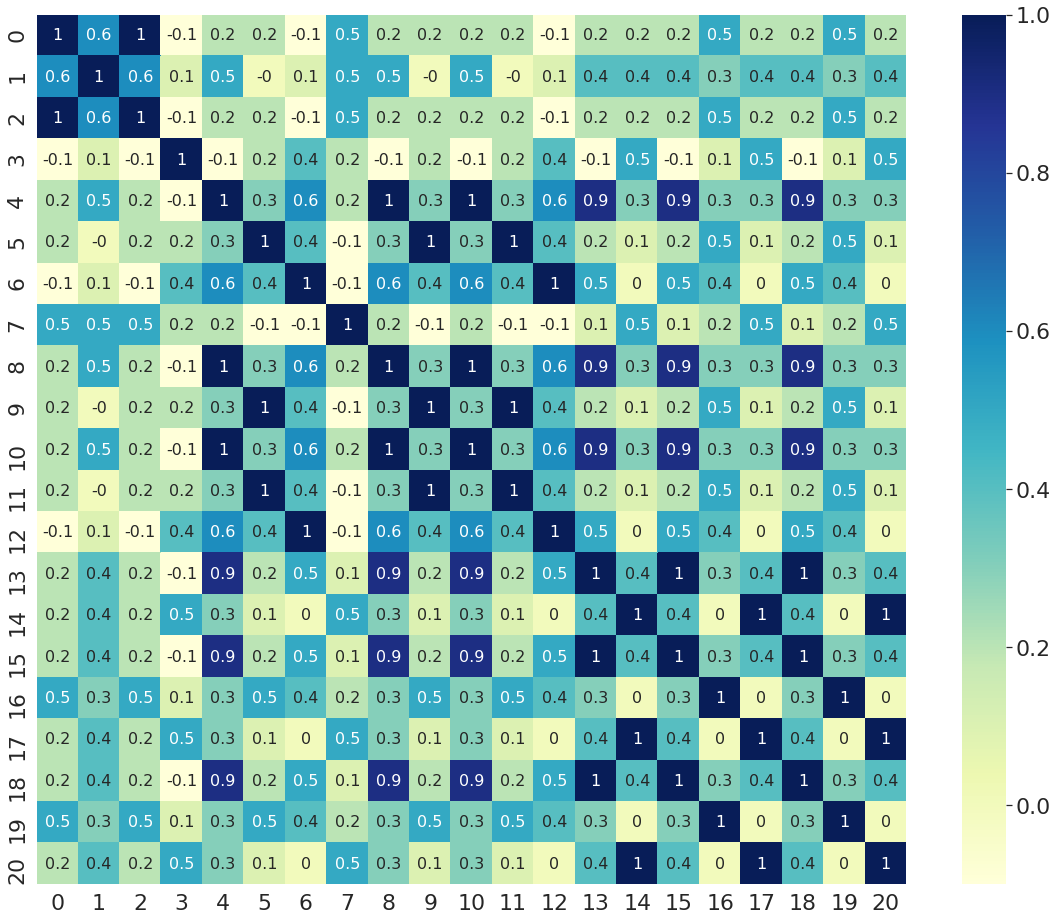

<Figure size 1800x1200 with 0 Axes>

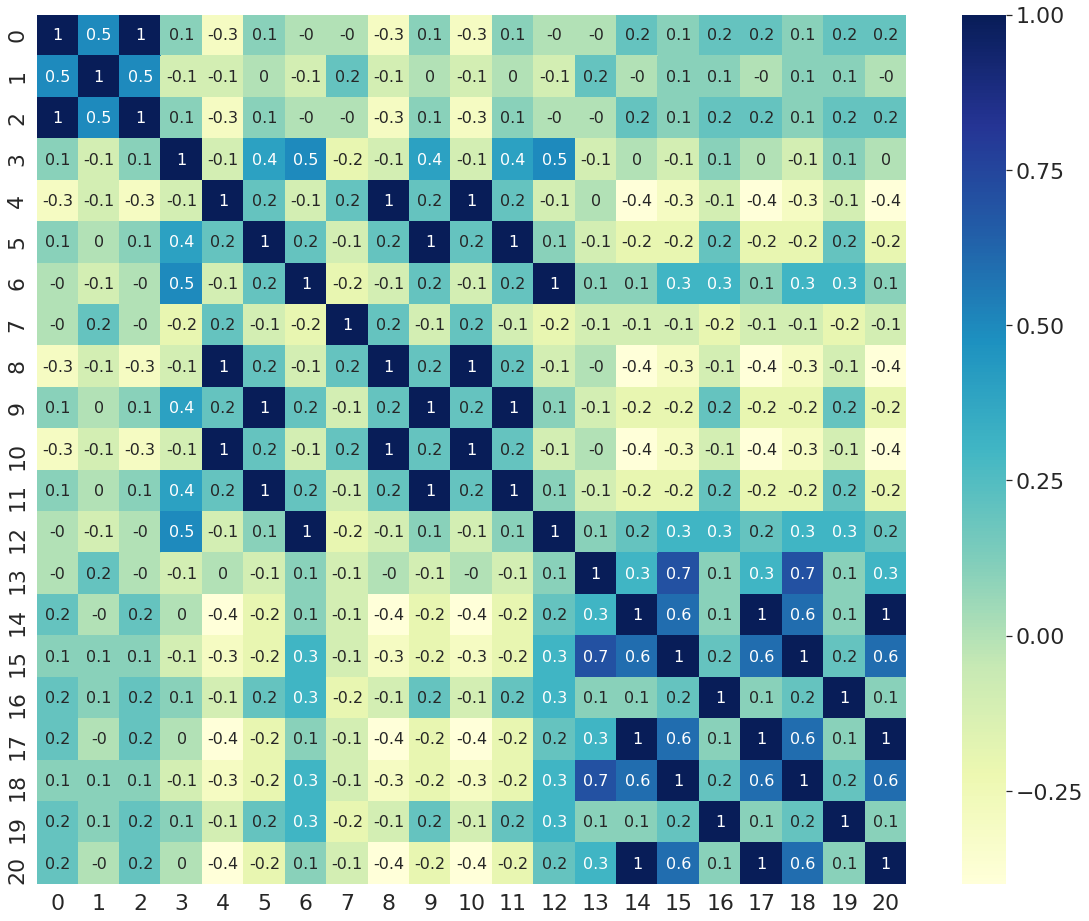

<Figure size 1800x1200 with 0 Axes>

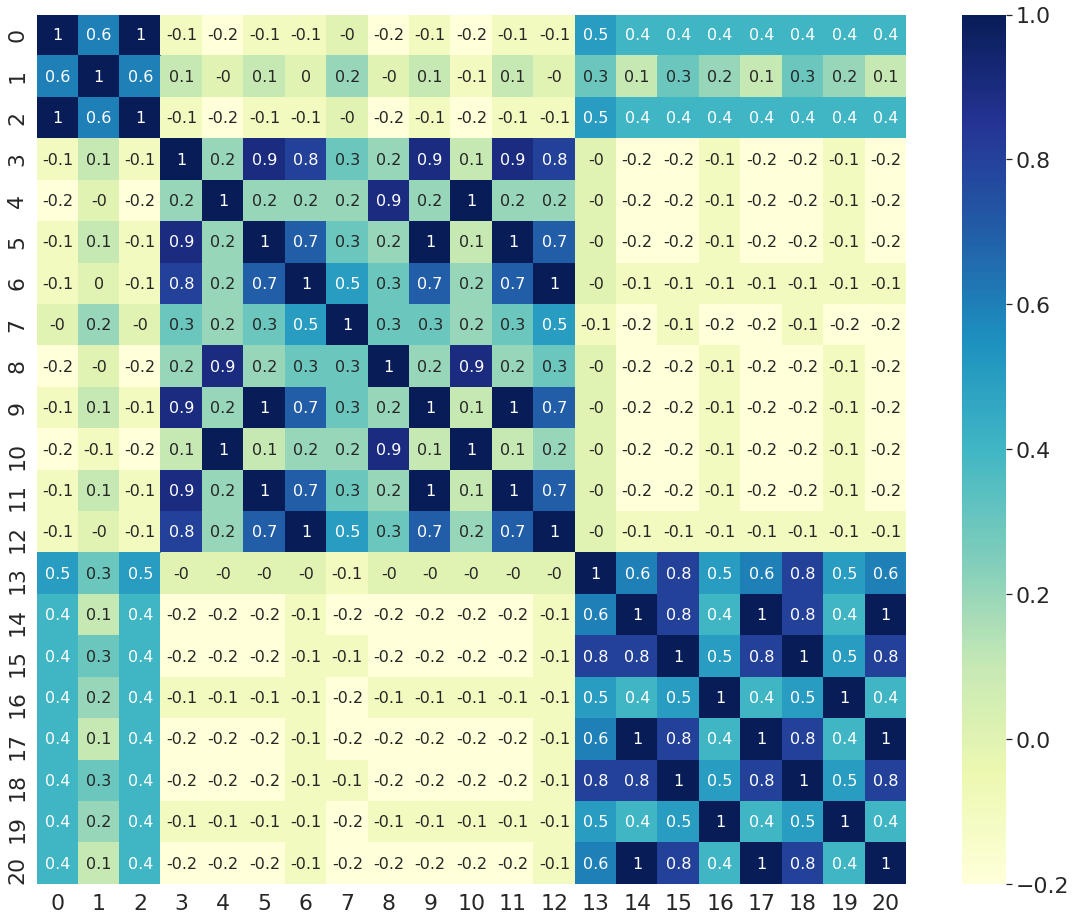

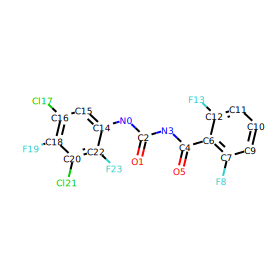

<Figure size 1800x1200 with 0 Axes>

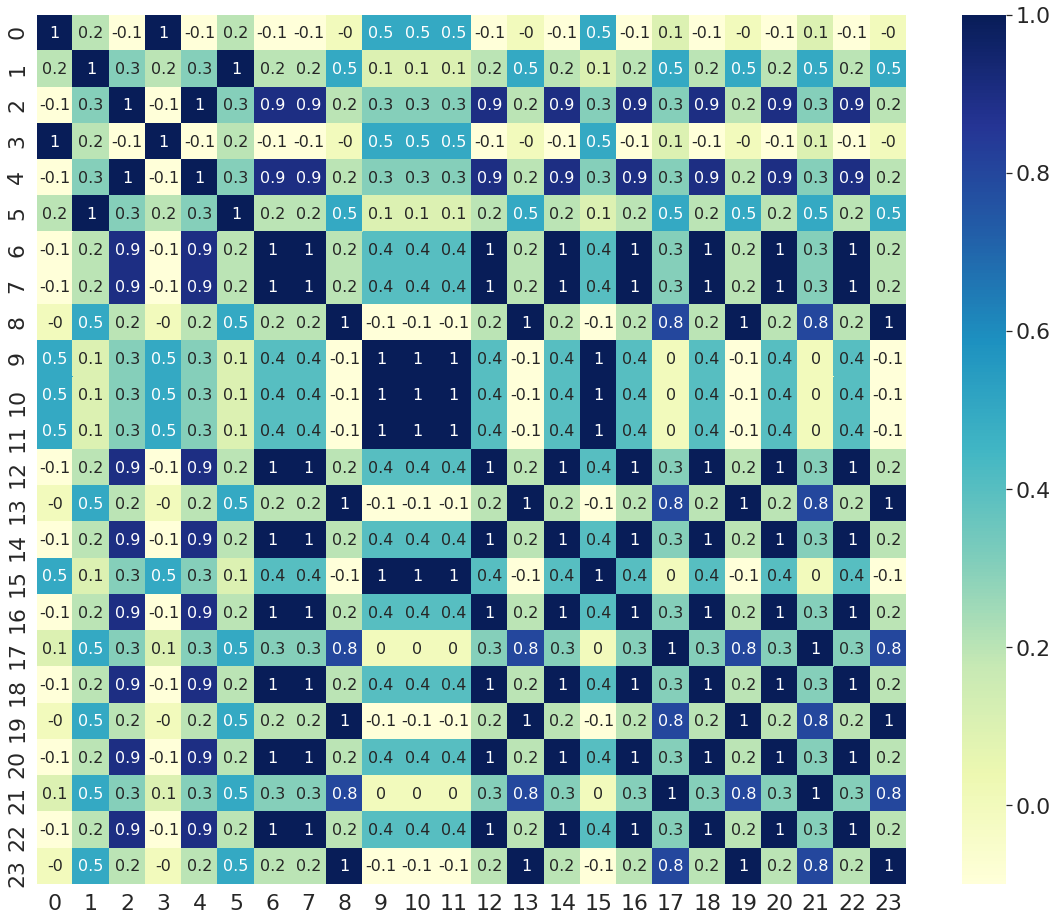

<Figure size 1800x1200 with 0 Axes>

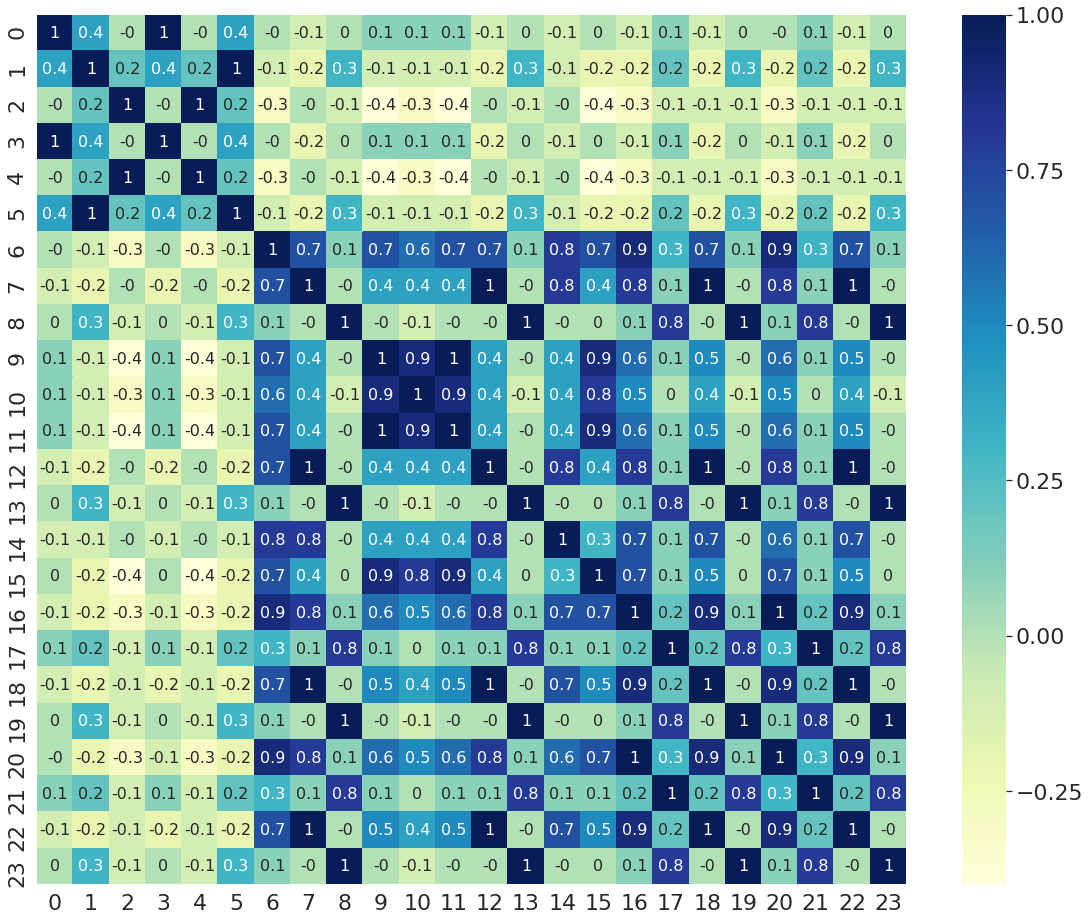

<Figure size 1800x1200 with 0 Axes>

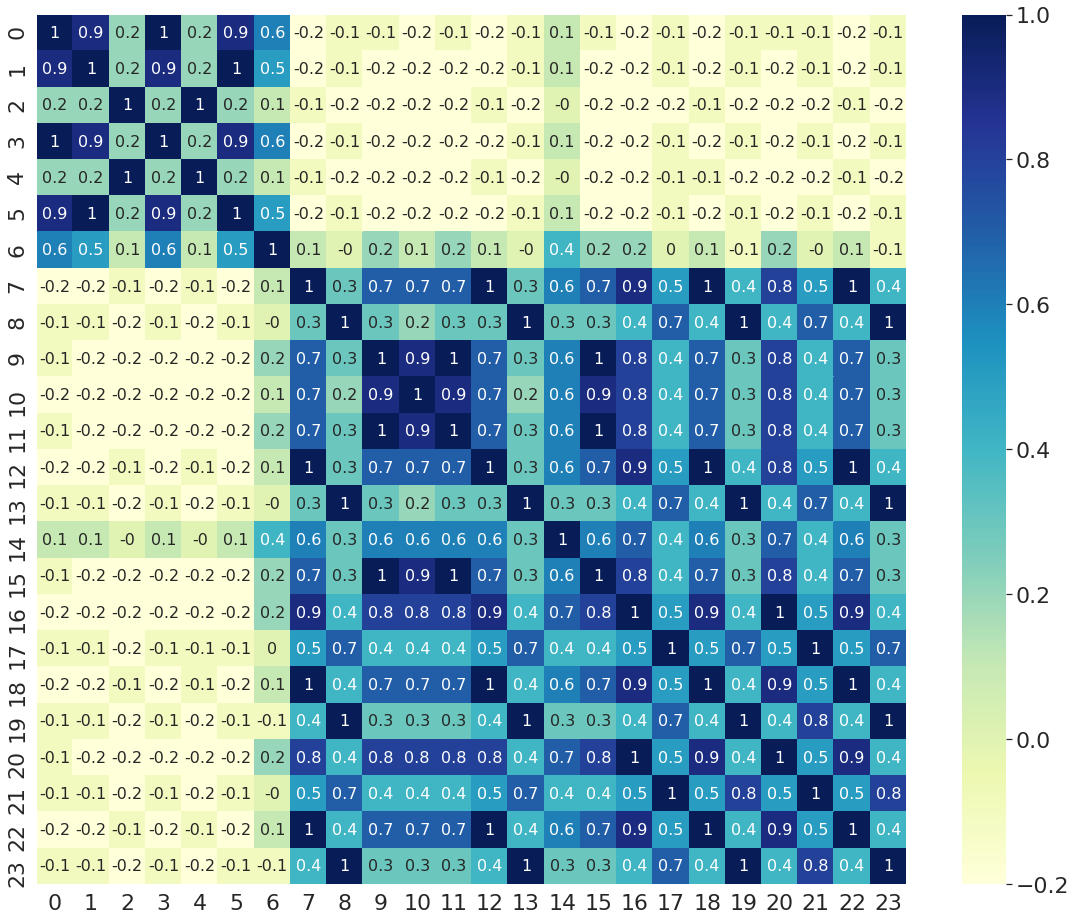

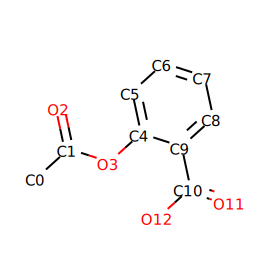

<Figure size 1800x1200 with 0 Axes>

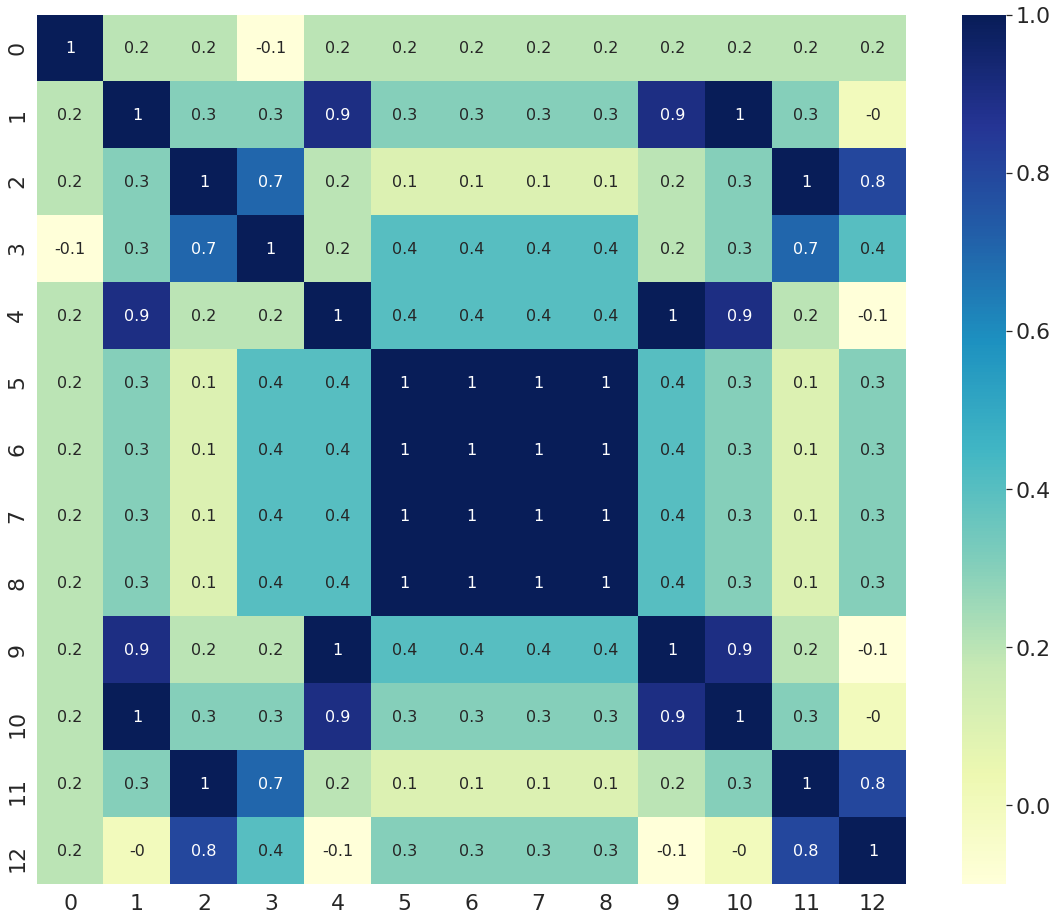

<Figure size 1800x1200 with 0 Axes>

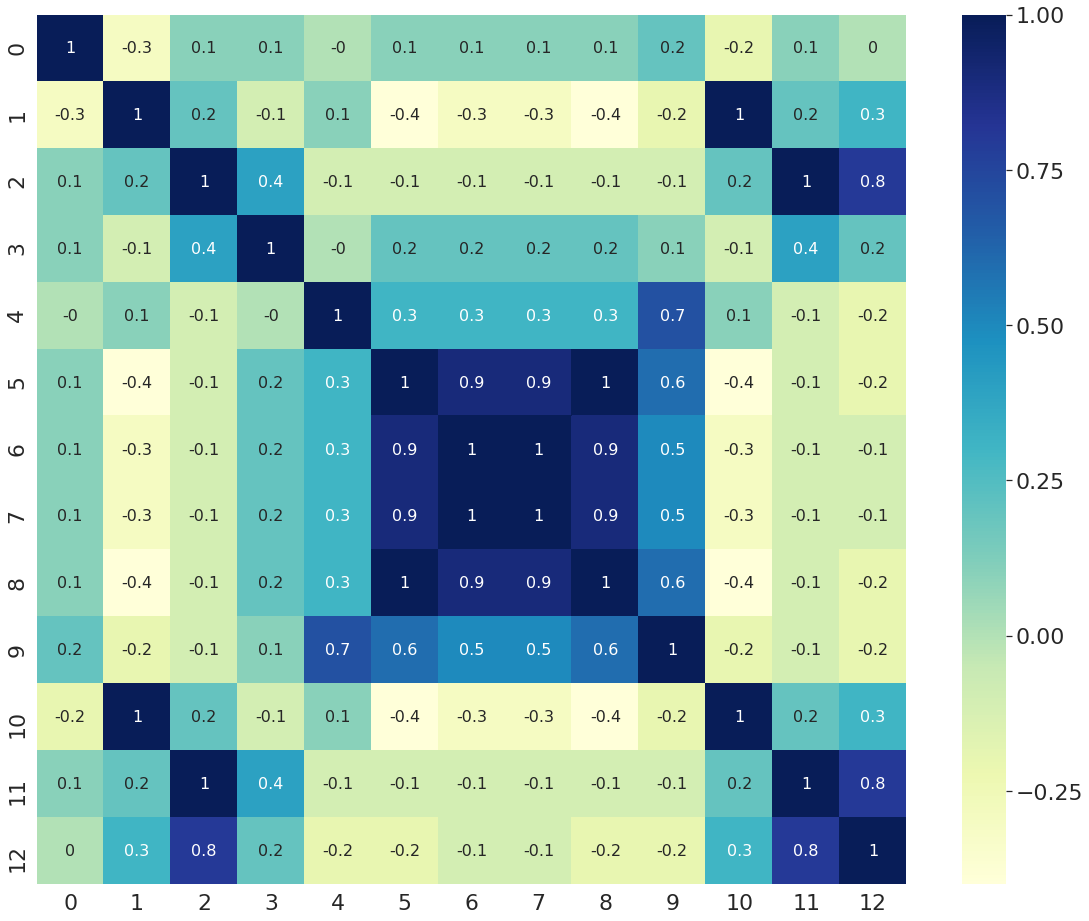

<Figure size 1800x1200 with 0 Axes>

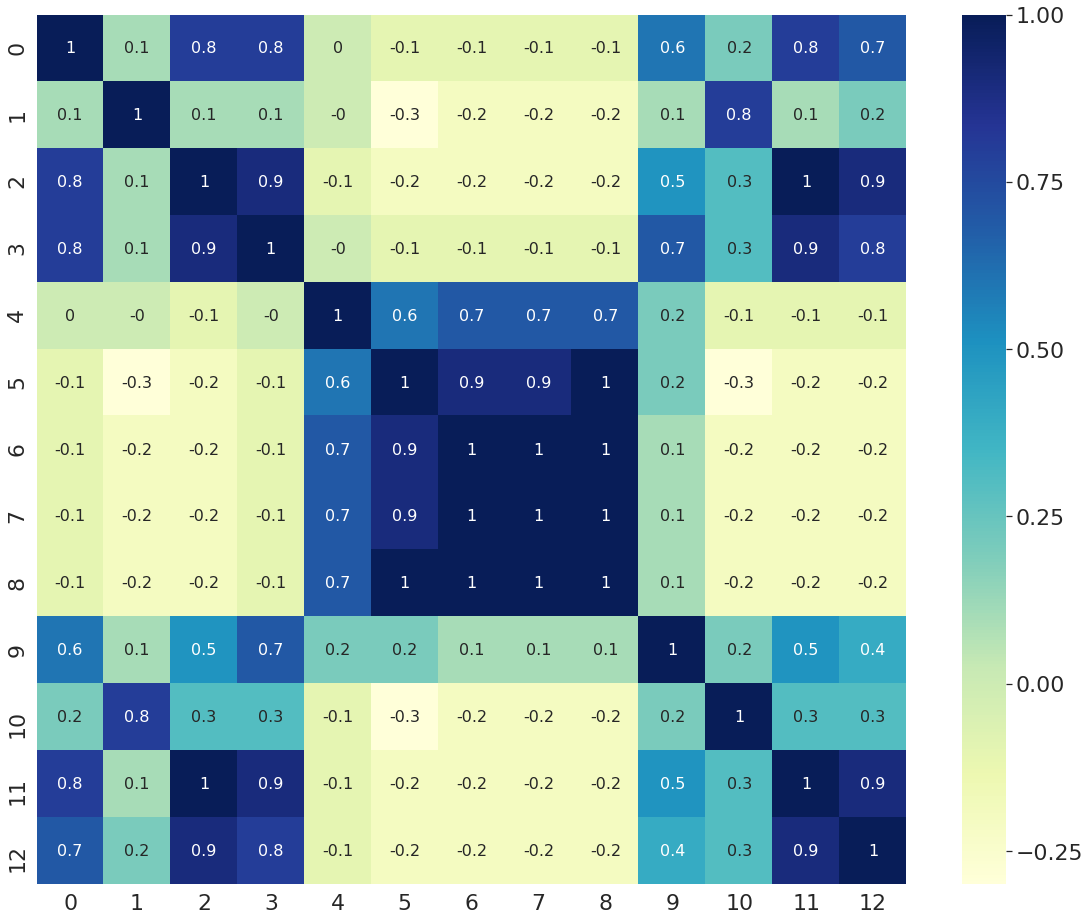

In [14]:
feature_sorted = []
weight_sorted = []

for i, smiles in enumerate(viz_list):
#     draw molecules in svg format
    atom_mask = x_mask[i]
    index_atom = smiles_to_rdkit_list[smiles]
    atom_feature = atom_feature_array[:, i]
    atom_weight = atom_weight_array[:, i]
    mol_prediction = mol_prediction_array[i]
    mol_feature = mol_feature_array[:, i]
    feature_list = []
    weight_list = []
    feature_reorder = []
    weight_reorder = []
    for j, one_or_zero in enumerate(atom_mask):
        if one_or_zero == 1.0:
            feature_list.append(atom_feature[:,j])
            weight_list.append(atom_weight[:,j])
            
    feature_reorder = np.stack([feature_list[m] for m in np.argsort(index_atom)])
    weight_reorder = np.stack([weight_list[m] for m in np.argsort(index_atom)])
#     reorder for draw
    if i == 0:    
        draw_index = [0,1,2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,10,11]
        feature_reorder = np.stack([feature_reorder[m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([weight_list[m] for m in np.argsort(draw_index)])
    elif i == 1:
        draw_index = [1,2,3,4,5,6,7,8,9,10,11,12,13,0,14,15,16,17,18,19,20,21,22,23]
        feature_reorder = np.stack([feature_reorder[m] for m in np.argsort(draw_index)])
        weight_reorder = np.stack([weight_list[m] for m in np.argsort(draw_index)])
    else: # using rdkit index directly
        draw_index = list(range(len(index_atom)))
#     print(feature_reorder[0].shape,weight_list[0].shape)
    feature_sorted.append(feature_reorder)
    weight_sorted.append(weight_reorder)
    
    mol = Chem.MolFromSmiles(smiles)

    drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
    drawer.SetFontSize(0.56)
    op = drawer.drawOptions()
    for index, re_index in enumerate(draw_index):
        op.atomLabels[index]=mol.GetAtomWithIdx(index).GetSymbol() + str(re_index)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg2 = svg.replace('svg:','')
    svg3 = SVG(svg2)
    display(svg3)
    
    intra_mol_correlation = [np.corrcoef(feature_reorder[:,L]) for L in range(radius+1)]
    sns.set(font_scale=2)
    
    for L in range(radius+1):
        plt.figure(dpi=300)
        fig, ax = plt.subplots(figsize=(20,16))
        mask = np.zeros_like(intra_mol_correlation[L])
        mask[np.triu_indices_from(mask)] = False
        sns.heatmap(np.around(intra_mol_correlation[L],1),cmap="YlGnBu", annot=True, ax=ax, mask=mask, square=True, annot_kws={"size": 16})
    plt.show()
    plt.close()
        

In [15]:
test_MAE_list = []
test_MSE_list = []

out_feature_sorted = []
out_weight_sorted = []
mol_feature_sorted = []
mol_feature_unbounded_sorted = []
# partial_charge_list = []
# refractivity_list = []
# mol_refractivity_list = []
# log_p_list = []
mol_LogP_list = []
mol_TPSA_list = []
mol_DrugLike_list = []
mol_SAScore_list = []

batch_list = []
dataset = remained_df.reset_index(drop=True)
valList = np.arange(0,dataset.shape[0])
for i in range(0, dataset.shape[0], batch_size):
    batch = valList[i:i+batch_size]
    batch_list.append(batch) 
for counter, batch in enumerate(batch_list):
    batch_df = dataset.loc[batch,:]
    smiles_list = batch_df.cano_smiles.values
    y_val = batch_df[tasks[0]].values

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)

    atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, mol_attention_weight_viz, mol_prediction = model_for_viz(
        torch.Tensor(x_atom), torch.Tensor(x_bonds),
        torch.cuda.LongTensor(x_atom_index),
        torch.cuda.LongTensor(x_bond_index),
        torch.Tensor(x_mask))
    
    MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction="none")        
    MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction="none")        
    test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
    test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

    mol_pred = np.array(mol_prediction.cpu().detach().numpy().squeeze())
    atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
    atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
    mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T+1)])
    mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
    mol_feature_unbounded = np.stack([mol_feature_unbounded_viz[t].cpu().detach().numpy() for t in range(T+1)])
    mol_feature_unbounded_sorted.extend([mol_feature_unbounded[:,i,:] for i in range(mol_feature_unbounded.shape[1])])
    for i, smiles in enumerate(smiles_list):
        ind_mask = x_mask[i]
        ind_atom = smiles_to_rdkit_list[smiles]
        ind_feature = atom_feature[:, i]
        ind_weight = atom_weight[:, i]
        out_atom = []
        out_pred = []
        out_feature = []
        out_weight = []
        for j, one_or_zero in enumerate(list(ind_mask)):
            if one_or_zero == 1.0:
                out_feature.append(ind_feature[:,j])
                out_weight.append(ind_weight[:,j])
        out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
        out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        
        
        mol = Chem.MolFromSmiles(smiles)
        mol_Crippen = rdMolDescriptors.CalcCrippenDescriptors(mol)
        mol_LogP_list.append(mol_Crippen[0])
        mol_TPSA = MolSurf.TPSA(mol)
        mol_TPSA_list.append(mol_TPSA)
        mol_QED = QED.qed(mol)
        mol_DrugLike_list.append(mol_QED)
        mol_SAScore = sascorer.calculateScore(mol)
        mol_SAScore_list.append(mol_SAScore)


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


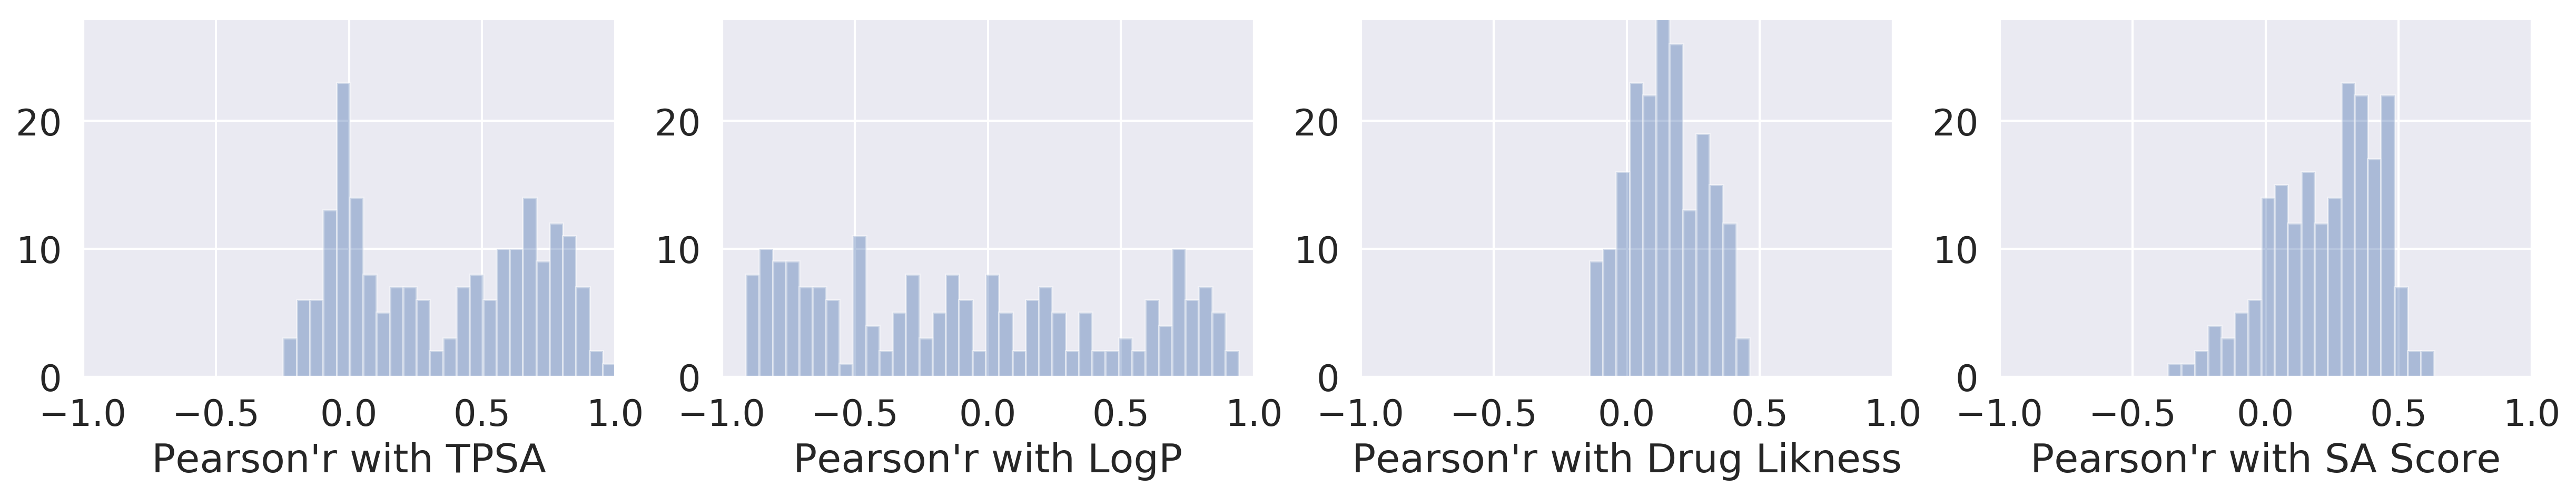

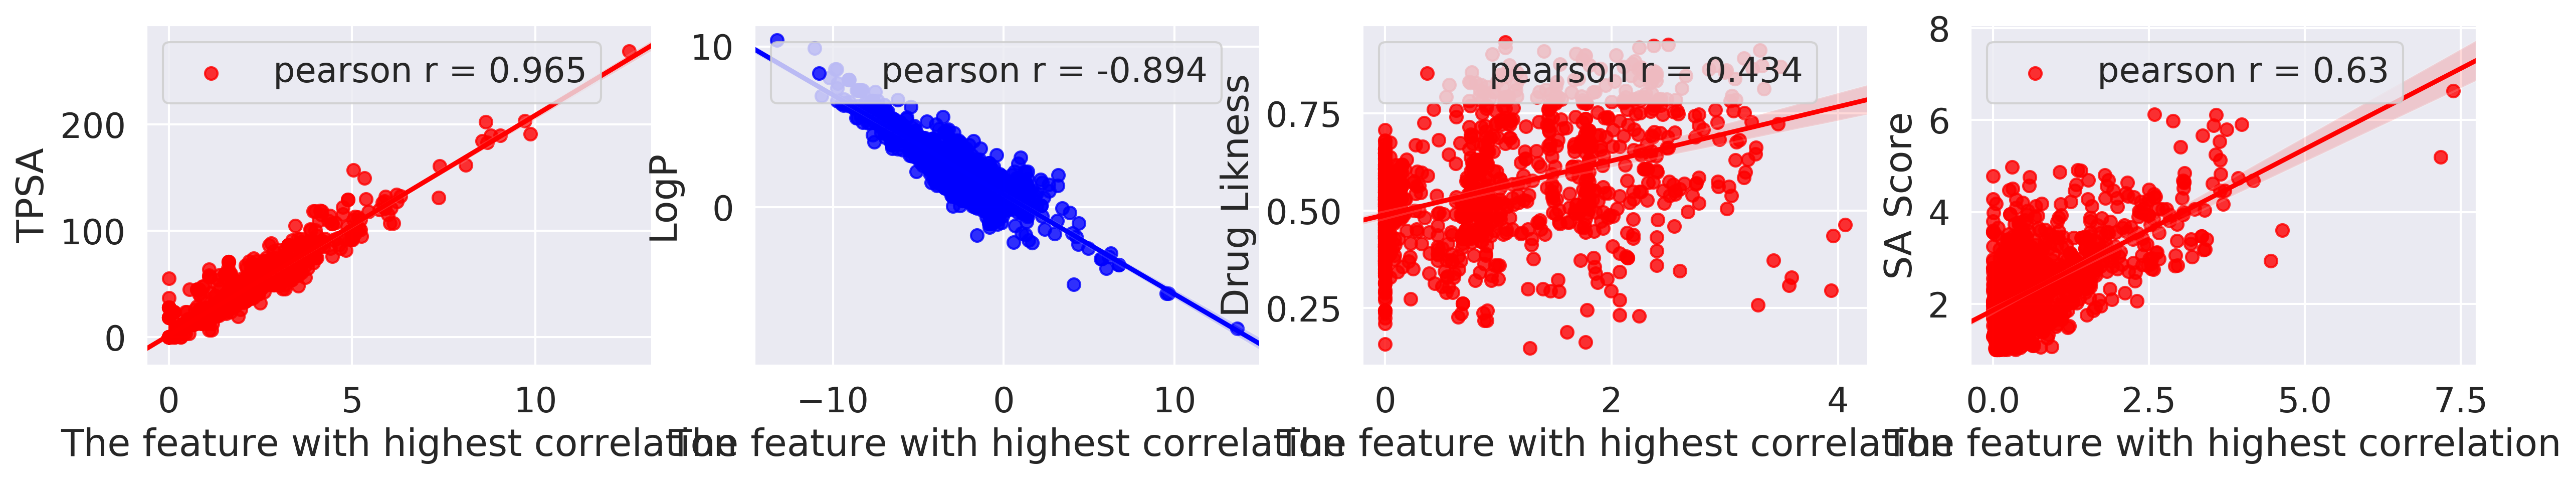

In [16]:
mol_feature_sorted = np.array(mol_feature_sorted)
mol_feature_unbounded_sorted = np.array(mol_feature_unbounded_sorted)
# print(mol_feature_sorted.shape)
descriptors_name = ["TPSA", "LogP", "Drug Likness", "SA Score"]
descriptors = [mol_TPSA_list, mol_LogP_list, mol_DrugLike_list, mol_SAScore_list]


TPSA_r_list = np.array([scipy.stats.pearsonr(mol_feature_sorted[:,0,i], mol_TPSA_list)[0] for i in range(fingerprint_dim)])
DrugLike_r_list = np.array([scipy.stats.pearsonr(mol_feature_sorted[:,0,i], mol_DrugLike_list)[0] for i in range(fingerprint_dim)])
SAScore_r_list = np.array([scipy.stats.pearsonr(mol_feature_sorted[:,0,i], mol_SAScore_list)[0] for i in range(fingerprint_dim)])
LogP_r_list = np.array([scipy.stats.pearsonr(mol_feature_unbounded_sorted[:,0,i], mol_LogP_list)[0] for i in range(fingerprint_dim)])
correlation_list = np.array([TPSA_r_list, LogP_r_list, DrugLike_r_list, SAScore_r_list])
correlation_list[np.isnan(correlation_list)] = 0
# print(correlation_list.shape)

plt.figure(figsize=(20, 3),dpi=300)
gs = gridspec.GridSpec(1, 4)
sns.set(font_scale=1.5)

for i, name in enumerate(descriptors_name):
    # plot Peason's r distribution
    x = pd.Series(correlation_list[i], name="Pearson\'r with "+name)
    ax0 = plt.subplot(gs[(i)])
    b_width = 0.05  # chose an arbitrary value here
    bin_num = np.arange(min(x), max(x) + b_width, b_width)
    sns.distplot(x, bins=bin_num, kde=False, ax=ax0)
    ax0.set_xlim([-1, 1])
    ax0.set_ylim([0, 28])
plt.show()
plt.close()

# plot the feature with highest correlation
def get_highest_correlation(feature, descriptor, peason_r_list):
    if max(peason_r_list,key=abs) > 0:
        top_index = peason_r_list.argsort()[-1]
    else:
        top_index = peason_r_list.argsort()[1]
    top_r = peason_r_list[top_index]
    return top_r, feature[:,0,top_index]

top_r_TPSA, highest_with_TPSA = get_highest_correlation(mol_feature_sorted, descriptors[0], correlation_list[0])
top_r_LogP, highest_with_LogP = get_highest_correlation(mol_feature_unbounded_sorted, descriptors[1], correlation_list[1])
top_r_DrugLike, highest_with_DrugLike = get_highest_correlation(mol_feature_sorted, descriptors[2], correlation_list[2])
top_r_SAScore, highest_with_SAScore = get_highest_correlation(mol_feature_sorted, descriptors[3], correlation_list[3])
highest_correlated_feature = [highest_with_TPSA, highest_with_LogP, highest_with_DrugLike, highest_with_SAScore]
top_r_list = [top_r_TPSA, top_r_LogP, top_r_DrugLike, top_r_SAScore]

plt.figure(figsize=(20, 3),dpi=300)
gs = gridspec.GridSpec(1, 4)
for i, name in enumerate(descriptors_name):
    
    x, y = pd.Series(highest_correlated_feature[i], name="The feature with highest correlation"), pd.Series(descriptors[i], name=name)

    ax1 = plt.subplot(gs[(i)])
    if top_r_list[i] >0:
        sns.regplot(x=x, y=y, color="red", label='pearson r = '+str(np.around(top_r_list[i],decimals=3)),ax=ax1)
    else:
        sns.regplot(x=x, y=y, color="blue", label='pearson r = '+str(np.around(top_r_list[i],decimals=3)),ax=ax1)
    ax1.legend(loc='upper left')
    # plt.tight_layout()
plt.show()
plt.close()
